<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/PreferredAI/tutorials/blob/master/recommender-systems/09_deep_learning.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/PreferredAI/tutorials/blob/master/recommender-systems/09_deep_learning.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

# Deep Learning

Recently deep learning has produced significant advancements on various machine learning tasks. To develop an appreciation of how deep learning has an effect on recommender systems, in this tutorial we look into example models from two broad categories. One models collaborative filtering or user-item interaction data, while the other models content associated with items (or users).

## 1. Setup

In [1]:
!pip install --quiet cornac

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.4/21.4 MB 42.9 MB/s eta 0:00:00


In [2]:
import os
import sys

import cornac
from cornac.data import Reader
from cornac.datasets import movielens, citeulike
from cornac.eval_methods import RatioSplit
from cornac.models import GMF, MLP, NeuMF, VAECF, CDL, ConvMF, WMF, CTR
from cornac.data import TextModality
from cornac.data.text import BaseTokenizer

import tensorflow as tf

print(f"System version: {sys.version}")
print(f"Cornac version: {cornac.__version__}")
print(f"Tensorflow version: {tf.__version__}")

SEED = 42
VERBOSE = True

System version: 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
Cornac version: 2.1
Tensorflow version: 2.15.0


## 2. Deep Learning for Collaborative Filtering

In this section, we study two frameworks of deep learning, and how they can be used to model user-item interactions.  Neural collaborative filtering is based on multi-layer perceptrons, while as suggested by its name, variational autoencoder for collaborative filtering is based on VAE.


### Neural Collaborative Filtering

Neural collaborative filtering consists of a family of models developed based on neural networks to tackle the problem of collaborative filtering based on implicit feedback.  The final model NeuMF is a combination of two components, namely Generalized Matrix Factorization (GMF) and Multi-Layer Perceptrons (MLP), which are also independent models respectively.

- GMF projects element-wise product between user and item embedding vectors through *Sigmoid* function to out the prediction:
<!-- \begin{equation}
\hat{y}_{ij} = \sigma \big(\mathbf{w}^T (\mathbf{u}_i \odot \mathbf{v}_j)\big) = \sigma \big(\sum_{k=1}^{K} w_k . u_{ik} . v_{jk}\big)
\end{equation} -->
<p align="center">
  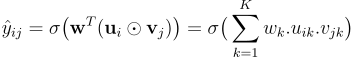
</p>
where $\odot$ is element-wise product, $\mathbf{u}_i$ and $\mathbf{v}_j$ are user and item embeddings, $\mathbf{w}$ are the projection weights, and $\sigma$ is the *Sigmoid* function.

- MLP projects concatenation of user and item embeddings through multiple layers:
<!-- \begin{align*}
\mathbf{z}_1 & = \phi_1 (\mathbf{u}_i, \mathbf{v}_j) = \begin{bmatrix} \mathbf{u}_i\\ \mathbf{v}_j \end{bmatrix} \\
\mathbf{z}_2 & = \phi_2 (\mathbf{w}_2^T \mathbf{z}_1 + b_2) \\
\vdots & \\
\mathbf{z}_L & = \phi_L (\mathbf{w}_L^T \mathbf{z}_{L-1} + b_L) \\
\hat{y}_{ij} & = \sigma (\mathbf{w}_{L+1}^T \mathbf{z}_L)
\end{align*} -->
<p align="center">
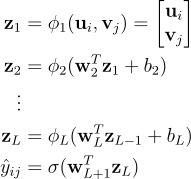
</p>
where $\phi$ is a non-linear activation function (could be *Tanh* as recommended by the authors).

- NeuMF is a fusion of GMF and MLP:
<!-- \begin{equation}
\hat{y}_{ij} = \sigma \bigg(\mathbf{w}^T \begin{bmatrix} \mathbf{u}_i \odot \mathbf{v}_j \\ \mathbf{z}_L \end{bmatrix} \bigg)
\end{equation} -->
<p align="center">
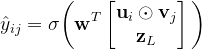
</p>

The models are learned by minimizing log-loss function:
<!-- \begin{align*}
\mathcal{L}  & = - \sum_{(u,i) \in \mathbf{R}^+} \log \hat{y}_{ui} - \sum_{(u,i) \in \mathbf{R}^-} \log (1 - \hat{y}_{ui}) \\
& = - \sum_{(u,i) \in \mathbf{R}^+ \cup \mathbf{R}^- } y_{ui} \log \hat{y}_{ui} + (1 - y_{ui}) \log (1 - \hat{y}_{ui})
\end{align*} -->
<p align="center">
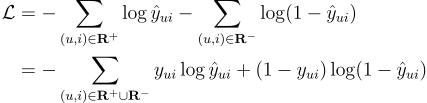
</p>

Let's try the models all together!

In [3]:
GMF_FACTORS = 8  # @param
MLP_LAYERS = [32, 16, 8]  # @param
ACTIVATION = "tanh"  # @param ["tanh", "sigmoid", "relu", "leaky_relu"]
NEG_SAMPLES = 3  # @param
NUM_EPOCHS = 10  # @param
BATCH_SIZE = 256  # @param
LEARNING_RATE = 0.001  # @param

gmf = GMF(num_factors=GMF_FACTORS, num_epochs=NUM_EPOCHS, batch_size=BATCH_SIZE,
          num_neg=NEG_SAMPLES, lr=LEARNING_RATE, seed=SEED, verbose=VERBOSE)
mlp = MLP(layers=MLP_LAYERS, act_fn=ACTIVATION, num_epochs=NUM_EPOCHS, batch_size=BATCH_SIZE,
          num_neg=NEG_SAMPLES, lr=LEARNING_RATE, seed=SEED, verbose=VERBOSE)
neumf = NeuMF(num_factors=GMF_FACTORS, layers=MLP_LAYERS, act_fn=ACTIVATION, num_epochs=NUM_EPOCHS,
              num_neg=NEG_SAMPLES, batch_size=BATCH_SIZE, lr=LEARNING_RATE, seed=SEED, verbose=VERBOSE)

wmf = WMF(k=GMF_FACTORS, max_iter=200, learning_rate=0.001, seed=SEED, verbose=VERBOSE)

ml_100k = movielens.load_feedback(variant="100K", reader=Reader(bin_threshold=4.0))
ratio_split = RatioSplit(
  data=ml_100k, test_size=0.2, exclude_unknowns=True, seed=SEED, verbose=VERBOSE
)
ndcg_50 = cornac.metrics.NDCG(k=50)
rec_50 = cornac.metrics.Recall(k=50)

cornac.Experiment(
  eval_method=ratio_split,
  models=[gmf, mlp, neumf, wmf],
  metrics=[ndcg_50, rec_50],
).run()

Data from http://files.grouplens.org/datasets/movielens/ml-100k/u.data
will be cached into /root/.cornac/ml-100k/u.data


0.00B [00:00, ?B/s]

File cached!
rating_threshold = 1.0
exclude_unknowns = True
---
Training data:
Number of users = 942
Number of items = 1420
Number of ratings = 44300
Max rating = 1.0
Min rating = 1.0
Global mean = 1.0
---
Test data:
Number of users = 942
Number of items = 1420
Number of ratings = 11044
Number of unknown users = 0
Number of unknown items = 0
---
Total users = 942
Total items = 1420

[GMF] Training started!


  0%|          | 0/10 [00:00<?, ?it/s]


[GMF] Evaluation started!


Ranking:   0%|          | 0/921 [00:00<?, ?it/s]


[MLP] Training started!


  0%|          | 0/10 [00:00<?, ?it/s]


[MLP] Evaluation started!


Ranking:   0%|          | 0/921 [00:00<?, ?it/s]


[NeuMF] Training started!


  0%|          | 0/10 [00:00<?, ?it/s]


[NeuMF] Evaluation started!


Ranking:   0%|          | 0/921 [00:00<?, ?it/s]


[WMF] Training started!


  0%|          | 0/200 [00:00<?, ?it/s]

Learning completed!

[WMF] Evaluation started!


Ranking:   0%|          | 0/921 [00:00<?, ?it/s]


TEST:
...
      | NDCG@50 | Recall@50 | Train (s) | Test (s)
----- + ------- + --------- + --------- + --------
GMF   |  0.2141 |    0.3294 |   30.0594 |   1.4045
MLP   |  0.2146 |    0.3347 |   23.6328 |   1.5569
NeuMF |  0.3421 |    0.5174 |   24.2053 |   1.5762
WMF   |  0.2627 |    0.4446 |   10.8766 |   0.9175



### Variational Autoencoder for Collaborative Filtering (VAECF)


Variational Autoencoders (VAE) is a type of autoencoders which is a neural network with auto-associative mapping of inputs.  Normal autoencoders learns a determinisic latent representation of an input, while VAE learns a distribution of that representation.  VAECF model extends VAE for the collaborative filtering problem with implicit feedback data.

Let the data for user $i$ (e.g., history clicks) be a vector $\mathbf{x}_i \in \mathbb{N}^M$ where M is the number of items.  The generative model of VAECF can be described as follows:

- User latent representation is sampled from standard Gaussion prior: $\mathbf{u}_i \sim \mathcal{N}(0, \mathbf{I}_K)$

- $\mathbf{z}_i$ is transformed via a non-linear function $f_{\theta}$ to produce a probability distribution over items (normalized using *softmax*): $\pi(\mathbf{u}_i) \propto \exp \{ f_{\theta}(\mathbf{u}_i) \}$

- User data $\mathbf{x}_i$ is assumed to have been drawn from the multinomial distribution: $\mathbf{x}_i \sim \mathrm{Mult}(N_i, \pi(\mathbf{u}_i))$

The Multinomial (*mult*) log-likelihood for user $i$ conditioned on the latent representation is:
<!-- \begin{equation}
\log p_{\theta} (\mathbf{x}_i | \mathbf{u}_i) = \mathcal{L}_{mult} = \sum_{i=1}^{N} \sum_{j=1}^{M} x_{ij} \log \pi_j(\mathbf{u}_i)
\end{equation} -->
<p align="center">
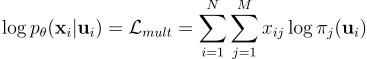
</p>

Other choices of likelihood including Bernoulli (*bern*), Gaussian (*gaus*), or Poisson (*pois*) can be used:
<!-- \begin{align*}
\mathcal{L}_{bern} &= \sum_{i=1}^{N} \sum_{j=1}^{M} x_{ij} \log \sigma(f_{\theta}(\mathbf{u}_i)_j) + (1 - x_{ij}) \log (1 - \sigma(f_{\theta}(\mathbf{u}_i)_j)) \\
\mathcal{L}_{gaus} &= \sum_{i=1}^{N} \sum_{j=1}^{M} - (x_{ij} - \sigma(f_{\theta}(\mathbf{u}_i)_j))^2  \\
\mathcal{L}_{pois} &= \sum_{i=1}^{N} \sum_{j=1}^{M} x_{ij} \log \sigma(f_{\theta}(\mathbf{u}_i)_j) - \sigma(f_{\theta}(\mathbf{u}_i)_j)
\end{align*} -->
<p align="center">
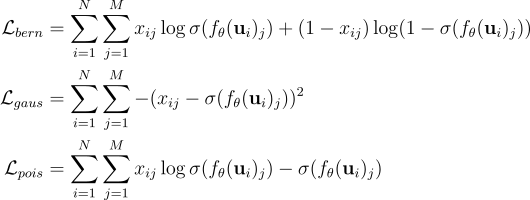
</p>



The encoder-decoder architecture is due to the use of amortized inference, a technique of variational inference, for learning the generative model (**decoder**) $f_{\theta}$.  Amortized inference learns an inference model (**encoder**) $g_{\phi} (\mathbf{x}_i) \equiv [\mu_{\phi}(\mathbf{x}_i), \sigma_{\phi}(\mathbf{x}_i)]$, which makes use of the observed data $\mathbf{x}_i$ to approximate the true intractable posterior $p(\mathbf{u}_i | \mathbf{x}_i)$ with a simpler variational distribution:
<!-- \begin{equation}
q_{\phi}(\mathbf{u}_i | \mathbf{x}_i) = \mathcal{N} (\mu_{\phi}(\mathbf{x}_i), \mathrm{diag}\{\sigma_{\phi}^2(\mathbf{x}_i)\})
\end{equation} -->
<p align="center">
  
</p>

Learning the model parameters $\{\theta, \phi\}$ is done via maximizing the evidence lower bound (ELBO):
<!-- \begin{equation}
\mathcal{L}_{\beta} = \mathbb{E}_{q_{\phi} (\mathbf{u}_i | \mathbf{x}_i)} [\log p_{\theta} (\mathbf{x}_i | \mathbf{u}_i)] - \beta . \mathrm{KL}(q_{\phi} (\mathbf{u}_i | \mathbf{x}_i) || p(\mathbf{u}_i))
\end{equation} -->
<p align="center">
  
</p>

where $\beta$ is a hyper-parameter to control the strength of regularization introduced by enforcing small Kullback-Leibler (KL) divergence between posterior $q_{\phi} (\mathbf{u}_i | \mathbf{x}_i)$ and the prior $p(\mathbf{u}_i)$.



In [4]:
NUM_FACTORS = 25  # @param
AE_LAYERS = [100, 50]  # @param
ACTIVATION = "tanh"  # @param ["tanh", "sigmoid", "relu", "leaky_relu"]
LIKELIHOOD = "bern"  # @param ["bern", "mult", "gaus", "pois"]
NUM_EPOCHS = 600  # @param
BATCH_SIZE = 256  # @param
LEARNING_RATE = 0.001  # @param

vaecf = VAECF(k=NUM_FACTORS, autoencoder_structure=AE_LAYERS, act_fn=ACTIVATION,
              likelihood=LIKELIHOOD, n_epochs=NUM_EPOCHS, batch_size=BATCH_SIZE,
              learning_rate=LEARNING_RATE, seed=SEED, verbose=VERBOSE, use_gpu=True)

wmf = WMF(k=NUM_FACTORS, max_iter=200, learning_rate=0.001, seed=SEED, verbose=VERBOSE)

ml_100k = movielens.load_feedback(variant="100K", reader=Reader(bin_threshold=4.0))
ratio_split = RatioSplit(
  data=ml_100k, test_size=0.2, exclude_unknowns=True, seed=SEED, verbose=VERBOSE
)

cornac.Experiment(
  eval_method=ratio_split, models=[vaecf, wmf], metrics=[rec_50, ndcg_50],
).run()

rating_threshold = 1.0
exclude_unknowns = True
---
Training data:
Number of users = 942
Number of items = 1420
Number of ratings = 44300
Max rating = 1.0
Min rating = 1.0
Global mean = 1.0
---
Test data:
Number of users = 942
Number of items = 1420
Number of ratings = 11044
Number of unknown users = 0
Number of unknown items = 0
---
Total users = 942
Total items = 1420

[VAECF] Training started!


  0%|          | 0/600 [00:00<?, ?it/s]


[VAECF] Evaluation started!


Ranking:   0%|          | 0/921 [00:00<?, ?it/s]


[WMF] Training started!


  0%|          | 0/200 [00:00<?, ?it/s]

Learning completed!

[WMF] Evaluation started!


Ranking:   0%|          | 0/921 [00:00<?, ?it/s]


TEST:
...
      | NDCG@50 | Recall@50 | Train (s) | Test (s)
----- + ------- + --------- + --------- + --------
VAECF |  0.3464 |    0.5102 |   21.2845 |   1.4173
WMF   |  0.2875 |    0.4939 |   11.7379 |   0.8807



## 3. Deep Learning for Content-Based Filtering

A different way to use deep learning is to model the content of items (or users).  The key idea is to derive low-dimensional representations from this content, originally in the form of text, images, etc., and to use these representations to enhance recommender systems in a similar way to content-based methods.  In the following, we illustrate two examples based on autoencoder and convolutional neural networks respectively.

### Collaborative Deep Learning (CDL)

CDL makes use of Stacked-Denoising Autoencoders (SDAE) to model item text content, with the objective of improving upon Collaborative Topic Regression (CTR) model making use of topic model for the similar purpose.  CDL is a hierarchical Bayesian model, the generative process is as follows:

- For each user $i$
  - Draw latent vector $\mathbf{u}_i \sim \mathcal{N}(0, \lambda^{-1} \mathbf{I})$
- For each item $j$
  - Put its corrupted content $\mathbf{x}_j^{0}$ through SDAE
  - Draw clean content $\mathbf{x}_j \sim \mathcal{N}(\mathbf{x}_L, \lambda^{-1}\mathbf{I})$
    - User middle representation $\mathbf{x}_j^{L/2}$
  - Draw item offset $\mathbf{\epsilon}_j \sim \mathcal{N}(0, \lambda^{-1} \mathbf{I})$
  - Set item latent vector $\mathbf{v}_j$ to be: $\mathbf{v}_j = \mathbf{\epsilon}_j + \mathbf{x}_j^{L/2}$
- For each user-item pair $(i, j)$
  - Draw rating $r_{ij} \sim \mathcal{N}(\mathbf{u}_i^T \mathbf{v}_j, c_{ij}^{-1})$

The confidence parameter $c_{ij}$ is defined similar to that for CTR:
<!-- \begin{equation}
c_{i,j} =
\begin{cases}
a & \mbox{if } r_{i,j} > 0 \\
b & \mbox{otherwise }
\end{cases}
\end{equation} -->
<p align="center">
  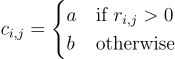
</p>

Learning CDL model is done via minimizing the loss function:
<!-- \begin{align*}
\mathcal{L} = & \frac{\lambda_u}{2} \sum_{i} || \mathbf{u}_i ||_2^2 + \frac{\lambda_w}{2} \sum_{l} (||\mathbf{W}_l||_F^2 + ||\mathbf{b}_l||^2) \\
& + \frac{\lambda_v}{2} \sum_{j} || \mathbf{v}_j - \mathbf{x}^{\frac{L}{2}}_{j} ||_2^2 \\
& + \frac{\lambda_n}{2} \sum_{j} || \mathbf{x}^{L}_{j} - \mathbf{x}^{c}_{j} ||_2^2 \\
& +  \sum_{i,j} \frac{c_{ij}}{2} (r_{ij} - \mathbf{u}_i^T \mathbf{v}_j)^2
\end{align*} -->
<p align="center">
  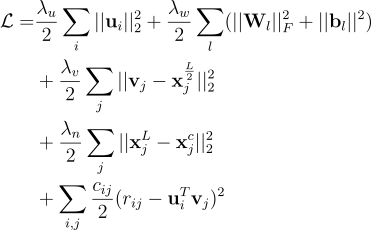
</p>

Let's do a comparison between CDL and CTR models.

In [5]:
VOCAB_SIZE = 2000  # @param
NUM_FACTORS = 50  # @param
AE_LAYERS = [500, 100]  # @param
ACTIVATION = "tanh"  # @param ["tanh", "sigmoid", "relu", "leaky_relu"]
A = 1.0  # @param
B = 0.01  # @param
LAMBDA_U = 0.1  # @param
LAMBDA_V = 0.1  # @param
LAMBDA_W = 0.1  # @param
LAMBDA_N = 10.0  # @param
CORRUPTION_RATE = 0.3  # @param
DROPOUT_RATE = 0.1  # @param
NUM_EPOCHS = 100  # @param
BATCH_SIZE = 100  # @param
LEARNING_RATE = 0.001  # @param

cdl = CDL(k=NUM_FACTORS, autoencoder_structure=AE_LAYERS, act_fn=ACTIVATION, a=A, b=B,
          lambda_u=LAMBDA_U, lambda_v=LAMBDA_V, lambda_w=LAMBDA_W, lambda_n=LAMBDA_N,
          corruption_rate=CORRUPTION_RATE, dropout_rate=DROPOUT_RATE, vocab_size=VOCAB_SIZE,
          max_iter=NUM_EPOCHS, batch_size=BATCH_SIZE, seed=SEED, verbose=VERBOSE)

ctr = CTR(k=NUM_FACTORS, max_iter=NUM_EPOCHS, a=A, b=B, lambda_u=LAMBDA_U, lambda_v=LAMBDA_V, seed=SEED, verbose=VERBOSE)

plots, movie_ids = movielens.load_plot()
feedback = movielens.load_feedback(variant="100k", reader=Reader(item_set=movie_ids, bin_threshold=4.0))
item_text_modality = TextModality(
  corpus=plots, ids=movie_ids, tokenizer=BaseTokenizer(sep="\t", stop_words="english"), max_vocab=VOCAB_SIZE,
)

ratio_split = RatioSplit(
  data=feedback,
  test_size=0.2,
  exclude_unknowns=True,
  item_text=item_text_modality,
  seed=SEED, verbose=VERBOSE,
)

cornac.Experiment(eval_method=ratio_split, models=[cdl, ctr], metrics=[rec_50, ndcg_50]).run()

Data from https://static.preferred.ai/cornac/datasets/movielens/ml_plot.zip
will be cached into /root/.cornac/movielens/ml_plot.dat


0.00B [00:00, ?B/s]

Unzipping ...
File cached!
rating_threshold = 1.0
exclude_unknowns = True
---
Training data:
Number of users = 942
Number of items = 1299
Number of ratings = 42303
Max rating = 1.0
Min rating = 1.0
Global mean = 1.0
---
Test data:
Number of users = 942
Number of items = 1299
Number of ratings = 10536
Number of unknown users = 0
Number of unknown items = 0
---
Total users = 942
Total items = 1299

[CDL] Training started!


  0%|          | 0/100 [00:00<?, ?it/s]

Learning completed!

[CDL] Evaluation started!


Ranking:   0%|          | 0/921 [00:00<?, ?it/s]


[CTR] Training started!


  0%|          | 0/100 [00:00<?, ?it/s]

Learning completed!

[CTR] Evaluation started!


Ranking:   0%|          | 0/921 [00:00<?, ?it/s]


TEST:
...
    | NDCG@50 | Recall@50 | Train (s) | Test (s)
--- + ------- + --------- + --------- + --------
CDL |  0.3201 |    0.5174 |   23.4677 |   0.8494
CTR |  0.2950 |    0.4671 |  102.5472 |   0.8458



### Convolutional Matrix Factorization (ConvMF)

ConvMF model integrates convolutional neural network (CNN) into probabilistic matrix factorization (PMF).  The model captures contextual information of item documents (e.g., reviews, abstracts, or synopses) and further enhances the rating prediction accuracy.  The generative process is as follows:

- For each user $i$
  - Draw latent vector $\mathbf{u}_i \sim \mathcal{N}(0, \lambda^{-1} \mathbf{I})$
- For each item $j$
  - Put its content $\mathbf{x}_j$ through CNN parameterized by $\mathbf{W}$
  - Draw item offset $\mathbf{\epsilon}_j \sim \mathcal{N}(0, \lambda^{-1} \mathbf{I})$
  - Set item latent vector $\mathbf{v}_j$ to be: $\mathbf{v}_j = \mathbf{\epsilon}_j + \mathrm{CNN}(\mathbf{W}, \mathbf{x}_j)$
- For each user-item pair $(i, j)$
  - Draw rating $r_{ij} \sim \mathcal{N}(\mathbf{u}_i^T \mathbf{v}_j, \sigma^2)$

Learning ConvMF model is done via minimizing the following negative log-likelihood function:
<!-- \begin{equation}
\mathcal{L} = \sum_{(i,j)\in \mathbf{R}} (r_{ij} - \mathbf{u}_i^T \mathbf{v}_j)^2 + \lambda_u \sum_{i}^{N} || \mathbf{u}_i ||^2 + \lambda_v \sum_{j}^{M} || \mathbf{v}_j - \mathrm{CNN}(\mathbf{W}, \mathbf{x}_j)||^2 +\lambda_\mathbf{W} \sum_{w_l \in \mathbf{W}} ||w_k||^2
\end{equation} -->
<p align="center">
  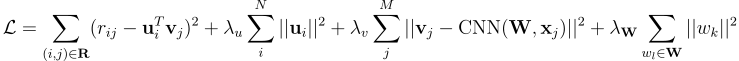
</p>


In [6]:
VOCAB_SIZE = 2000  # @param
NUM_FACTORS = 5  # @param
HIDDEN_DIM = 50  # @param
CNN_FILTER_SIZES = [2, 3, 4, 5]  # @param
CNN_NUM_FILTERS = 128  # @param
WORD_EMB_DIM = 32  # @param
SEQ_MAX_LENGTH = 50  # @param
DROPOUT_RATE = 0.2  # @param
LAMBDA_U = 0.1  # @param
LAMBDA_V = 0.1  # @param
NUM_EPOCHS = 5  # @param
CNN_EPOCHS = 3  # @param
CNN_BATCH_SIZE = 256  # @param
CNN_LEARNING_RATE = 0.001  # @param

convmf = ConvMF(k=NUM_FACTORS, n_epochs=NUM_EPOCHS, cnn_epochs=CNN_EPOCHS, cnn_bs=CNN_BATCH_SIZE,
                cnn_lr=CNN_LEARNING_RATE, emb_dim=WORD_EMB_DIM, max_len=SEQ_MAX_LENGTH,
                filter_sizes=CNN_FILTER_SIZES, num_filters=CNN_NUM_FILTERS, hidden_dim=HIDDEN_DIM,
                dropout_rate=DROPOUT_RATE, lambda_u=LAMBDA_U, lambda_v=LAMBDA_V,
                seed=SEED, verbose=VERBOSE)

plots, movie_ids = movielens.load_plot()
feedback = movielens.load_feedback(variant="100k", reader=Reader(item_set=movie_ids))
item_text_modality = TextModality(
  corpus=plots, ids=movie_ids, tokenizer=BaseTokenizer(sep="\t", stop_words="english"), max_vocab=VOCAB_SIZE,
)

ratio_split = RatioSplit(
  data=feedback,
  test_size=0.2,
  rating_threshold=4.0,
  exclude_unknowns=True,
  item_text=item_text_modality,
  seed=SEED,
  verbose=VERBOSE
)

rmse = cornac.metrics.RMSE()

cornac.Experiment(
  eval_method=ratio_split, models=[convmf], metrics=[rmse, rec_50], user_based=False
).run()

rating_threshold = 4.0
exclude_unknowns = True
---
Training data:
Number of users = 943
Number of items = 1518
Number of ratings = 75846
Max rating = 5.0
Min rating = 1.0
Global mean = 3.5
---
Test data:
Number of users = 943
Number of items = 1518
Number of ratings = 18933
Number of unknown users = 0
Number of unknown items = 0
---
Total users = 943
Total items = 1518

[ConvMF] Training started!
Epoch: 1/5


Optimizing CNN:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 321274.13787 Elapsed: 6.0745s Converge: 32127413786670662415245255403332059417891455287007641600.000000 
Epoch: 2/5


Optimizing CNN:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 67854.74705 Elapsed: 0.4130s Converge: 0.788795 
Epoch: 3/5


Optimizing CNN:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 65873.00846 Elapsed: 0.4294s Converge: 0.029206 
Epoch: 4/5


Optimizing CNN:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 68653.87447 Elapsed: 0.4246s Converge: 0.042216 
Epoch: 5/5


Optimizing CNN:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 71806.06221 Elapsed: 0.4385s Converge: 0.045914 

[ConvMF] Evaluation started!


Rating:   0%|          | 0/18933 [00:00<?, ?it/s]

Ranking:   0%|          | 0/942 [00:00<?, ?it/s]


TEST:
...
       |   RMSE | Recall@50 | Train (s) | Test (s)
------ + ------ + --------- + --------- + --------
ConvMF | 0.9806 |    0.0093 |   11.5233 |   0.7657



## References

1.   He, X., Liao, L., Zhang, H., Nie, L., Hu, X., & Chua, T. S. (2017, April). Neural collaborative filtering. In Proceedings of the 26th international conference on world wide web (pp. 173-182).
2.   Liang, D., Krishnan, R. G., Hoffman, M. D., & Jebara, T. (2018, April). Variational autoencoders for collaborative filtering. In Proceedings of the 2018 World Wide Web Conference (pp. 689-698).
3.   Wang, H., Wang, N., & Yeung, D. Y. (2015, August). Collaborative deep learning for recommender systems. In Proceedings of the 21th ACM SIGKDD international conference on knowledge discovery and data mining (pp. 1235-1244).
4.   Kim, D., Park, C., Oh, J., Lee, S., & Yu, H. (2016, September). Convolutional matrix factorization for document context-aware recommendation. In Proceedings of the 10th ACM conference on recommender systems (pp. 233-240).
5.   Cornac - A Comparative Framework for Multimodal Recommender Systems (https://cornac.preferred.ai/)